<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/DA2Dora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://huggingface.co/docs/transformers/main/en/model_doc/depth_anything_v2


# Depth Estimation with DoRA (Weight-Decomposed Low-Rank Adaptation)
# This notebook demonstrates how to add DoRA to a depth estimation model using PEFT

安裝依賴（不安裝也行，好像默認已經有了

In [ ]:
# Install required packages
!pip install transformers peft torch torchvision pillow requests matplotlib

加載模型，使用peft庫向模型添加DoRA塊。

Using device: cuda
Loading model and processor...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

Loading test image...
Image size: (640, 480)
Running inference with original model...


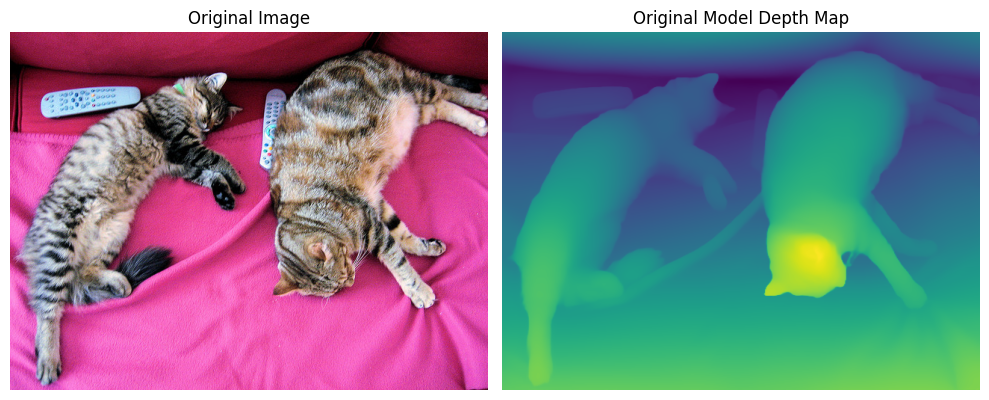

Configuring DoRA...
Applying DoRA to the model...
Running inference with dora model...


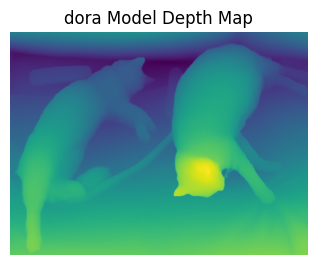

In [ ]:
# Depth Estimation with DoRA (Weight-Decomposed Low-Rank Adaptation)
# This notebook demonstrates how to add DoRA to a depth estimation model using PEFT

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from peft import get_peft_model, LoraConfig, TaskType
import copy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the original model and processor (we only need processor for reference, not for inference)
print("Loading model and processor...")
model_name = "depth-anything/Depth-Anything-V2-Small-hf"
image_processor = AutoImageProcessor.from_pretrained(model_name)  # Only for reference
original_model = AutoModelForDepthEstimation.from_pretrained(model_name)
original_model = original_model.to(device)

# Load test image
print("Loading test image...")
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
print(f"Image size: {image.size}")

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Function to preprocess image manually
def preprocess_image(image, target_size=(518, 518)):
    """Manually preprocess image to tensor"""
    # Resize image
    image_resized = image.resize(target_size, Image.LANCZOS)

    # Convert to numpy array and normalize
    image_array = np.array(image_resized).astype(np.float32)

    # Normalize to [0, 1]
    image_array = image_array / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image_array).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)

    # Normalize with ImageNet stats (typical for vision models)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    image_tensor = (image_tensor - mean) / std

    return image_tensor

# Function to run inference with manual preprocessing
def run_inference(model, image, original_size=None):
    """Run depth estimation inference with manual preprocessing"""
    if original_size is None:
        original_size = image.size

    # Manual preprocessing
    input_tensor = preprocess_image(image)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
      outputs = model(input_tensor)

    # Get predicted depth
    predicted_depth = outputs.predicted_depth

    # Resize back to original size
    predicted_depth_resized = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=original_size[::-1],  # (height, width)
        mode='bilinear',
        align_corners=False
    ).squeeze(1)

    # Normalize for visualization
    depth = predicted_depth_resized.squeeze(0)
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth.detach().cpu().numpy() * 255
    depth_image = Image.fromarray(depth.astype("uint8"))

    return depth_image, predicted_depth_resized

# Run inference with original model
print("Running inference with original model...")
original_depth, original_depth_tensor = run_inference(original_model, image)

# Display original depth map
plt.subplot(1, 2, 2)
plt.imshow(original_depth, cmap='viridis')
plt.title("Original Model Depth Map")
plt.axis('off')
plt.tight_layout()
plt.show()

# Configure DoRA (DoRA is enabled via use_dora=True in LoraConfig)
print("Configuring DoRA...")
dora_config = LoraConfig(

    r=8,  # Rank of adaptation
    # Target modules specific to vision transformers
    target_modules=[
        "query", "key", "value",  # Attention modules
        "dense",  # Dense layers in attention
    ],
    lora_dropout=0.1,
    use_dora=True,  # Enable DoRA (Weight-Decomposed Low-Rank Adaptation)
    bias="none",  # Don't adapt bias terms
)

# Apply DoRA to the model
print("Applying DoRA to the model...")
model_with_dora = get_peft_model(original_model, dora_config)
model_with_dora = model_with_dora.to(device)

print("Running inference with dora model...")
dora_depth, dora_depth_tensor = run_inference(model_with_dora, image)

# Display dora depth map
plt.subplot(1, 2, 2)
plt.imshow(dora_depth, cmap='viridis')
plt.title("dora Model Depth Map")
plt.axis('off')
plt.tight_layout()
plt.show()


輸出一些添加DoRA後模型的信息

In [ ]:
# Print model architecture to see DoRA modules
print("\nDoRA Model Architecture:")
print(model_with_dora)

# Print trainable parameters
print(f"\nTrainable parameters: {model_with_dora.num_parameters(only_trainable=True):,}")
print(f"Total parameters: {model_with_dora.num_parameters():,}")
print(f"Trainable percentage: {100 * model_with_dora.num_parameters(only_trainable=True) / model_with_dora.num_parameters():.2f}%")

隨機訓練模型，驗證只有DoRA塊的權重改變了

peft會重寫model.parameters()方法，確保它只返回應該被訓練的參數

Storing original weights...
Training completed. Loss: 0.998277

Verifying only LoRA parameters changed...
Changed parameters: 144
✓ Verification passed: Only LoRA parameters were updated during training
Running inference with dora model...


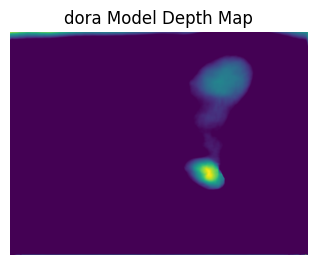

In [ ]:
# Store original weights for comparison
print("Storing original weights...")
model_with_dora.train()
original_weights = {}
for name, param in model_with_dora.named_parameters():
    if param.requires_grad:
        original_weights[name] = param.data.clone()

optimizer = torch.optim.AdamW(model_with_dora.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Prepare training data
input_tensor = preprocess_image(image).to(device)

# Create target (using original model output)
with torch.no_grad():
    target_outputs = original_model(pixel_values=input_tensor)
    target_depth = torch.randn_like(target_outputs.predicted_depth)

# Training step
model_with_dora.train()


for i in range(100):
  outputs = model_with_dora(pixel_values=input_tensor)
  loss = loss_fn(outputs.predicted_depth, target_depth)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f"Training completed. Loss: {loss.item():.6f}")

# Check which parameters changed and verify they're LoRA parameters
print("\nVerifying only LoRA parameters changed...")

changed_params = []
for name, param in model_with_dora.named_parameters():
    if param.requires_grad and name in original_weights:
        weight_change = torch.abs(param.data - original_weights[name]).max().item()
        if weight_change > 1e-8:
            changed_params.append(name)

print(f"Changed parameters: {len(changed_params)}")

# Assert all changed parameters contain 'lora'
for param_name in changed_params:
    assert 'lora' in param_name.lower(), f"Non-LoRA parameter changed: {param_name}"

print("✓ Verification passed: Only LoRA parameters were updated during training")

print("Running inference with dora model...")
dora_depth, dora_depth_tensor = run_inference(model_with_dora, image)

# Display dora depth map
plt.subplot(1, 2, 2)
plt.imshow(dora_depth, cmap='viridis')
plt.title("dora Model Depth Map, should be broken")
plt.axis('off')
plt.tight_layout()
plt.show()